In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score, pairwise_distances_argmin_min, silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [ ]:
path = os.path.abspath('..') + '/' + "datasets/model_dataset.csv"
df = pd.read_csv(path)
    
attack_cols = [
    'label_spoofing', 'label_mitm', 'label_ddos',
    'label_gps_spoofing', 'label_malware',
    'label_jamming', 'label_protocol_exploit'
]

df['anomaly_true'] = df[attack_cols].max(axis=1)

df = df.drop(['timestamp', 'drone_gps_coordinates', 'label_normal'], axis=1)
df = df.drop(columns=attack_cols)

categorical_cols = ['communication_protocol', 'encryption_type']

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(categorical_cols)
)

df = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

y_true = df['anomaly_true'].values

df = df.drop(columns=['anomaly_true'])


scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

=== CLASSIFICATION REPORT (K-Means Anomaly Detection) ===
              precision    recall  f1-score   support

           0       0.70      0.96      0.81     30500
           1       0.32      0.04      0.07     13430

    accuracy                           0.68     43930
   macro avg       0.51      0.50      0.44     43930
weighted avg       0.58      0.68      0.58     43930

Confusion Matrix:
 [[29337  1163]
 [12872   558]]


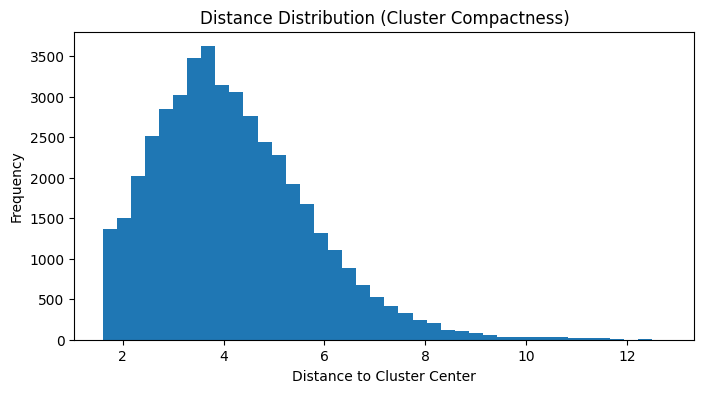

In [ ]:
k = 8  # normal vs anomaly
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_pca)

cluster_labels = kmeans.labels_

cluster_sizes = np.bincount(cluster_labels)
anomaly_cluster = np.argmin(cluster_sizes)

y_pred = (cluster_labels == anomaly_cluster).astype(int)

distances = np.linalg.norm(X_pca - kmeans.cluster_centers_[cluster_labels], axis=1)

df_results = pd.DataFrame({
    "cluster": cluster_labels,
    "distance": distances,
    "anomaly_pred": y_pred,
    "anomaly_true": y_true
})

print("=== CLASSIFICATION REPORT (K-Means Anomaly Detection) ===")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
#print("Confusion Matrix:\n", cm)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
cm_display.plot()
plt.show()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy*100)
print("Precision:", precision*100)
print("Recall:", recall*100)
print("F1 Score:", f1*100)

# BAR GRAPH
metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}
plt.bar(metrics.keys(), [v*100 for v in metrics.values()])
plt.ylabel("Percentage (%)")
plt.title("Model Performance Metrics")
plt.show()


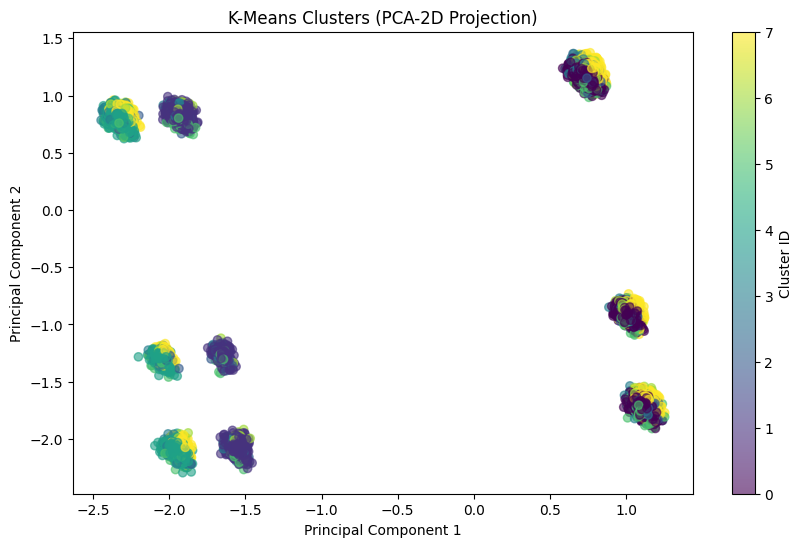

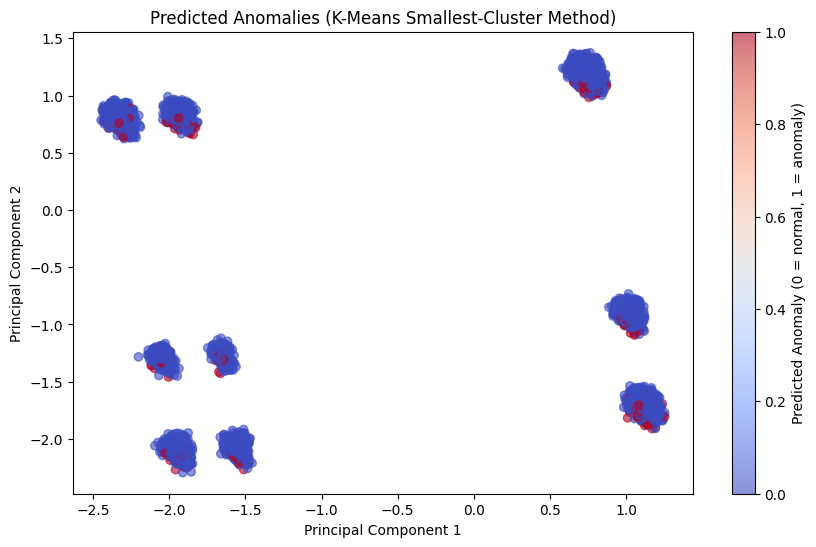

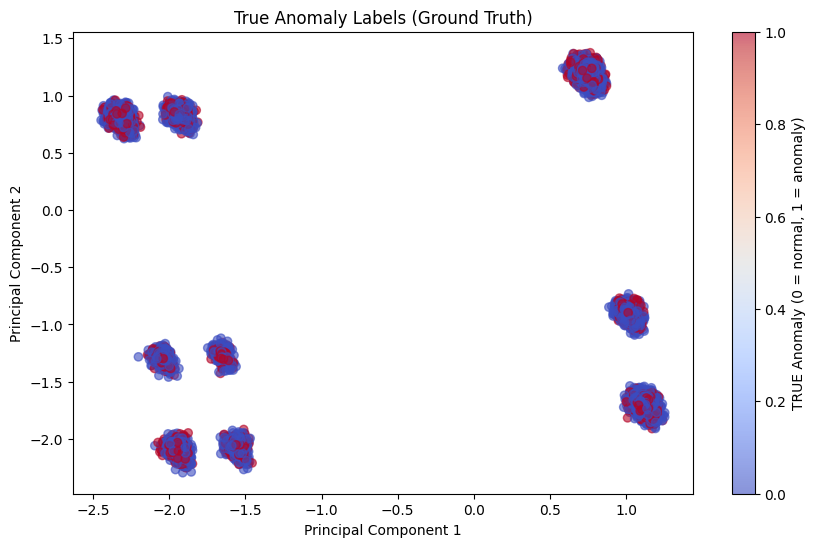

In [ ]:

# Plot distance histogram
plt.figure(figsize=(8,4))
plt.hist(distances, bins=40)
plt.title("Distance Distribution (Cluster Compactness)")
plt.xlabel("Distance to Cluster Center")
plt.ylabel("Frequency")
plt.show()

pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X_scaled)

df_plot = pd.DataFrame({
    'pc1': X_vis[:, 0],
    'pc2': X_vis[:, 1],
    'cluster': cluster_labels,
    'anomaly_pred': y_pred,
    'anomaly_true': y_true
})

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_plot['pc1'], df_plot['pc2'],
    c=df_plot['cluster'],
    cmap='viridis',
    alpha=0.6
)
plt.colorbar(scatter, label='Cluster ID')
plt.title("K-Means Clusters (PCA-2D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_plot['pc1'], df_plot['pc2'],
    c=df_plot['anomaly_pred'],
    cmap='coolwarm',
    alpha=0.6
)
plt.colorbar(scatter, label='Predicted Anomaly (0 = normal, 1 = anomaly)')
plt.title("Predicted Anomalies (K-Means Smallest-Cluster Method)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_plot['pc1'], df_plot['pc2'],
    c=df_plot['anomaly_true'],
    cmap='coolwarm',
    alpha=0.6
)
plt.colorbar(scatter, label='TRUE Anomaly (0 = normal, 1 = anomaly)')
plt.title("True Anomaly Labels (Ground Truth)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


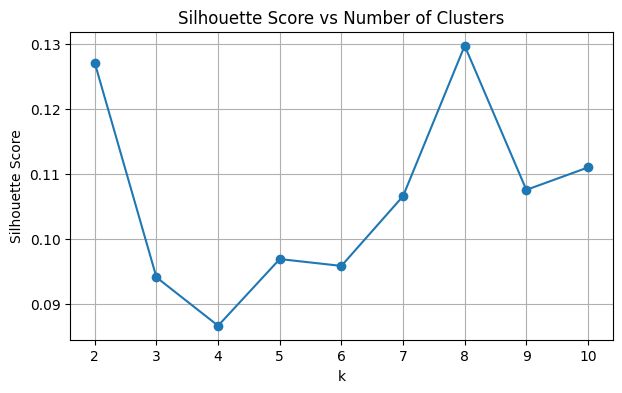

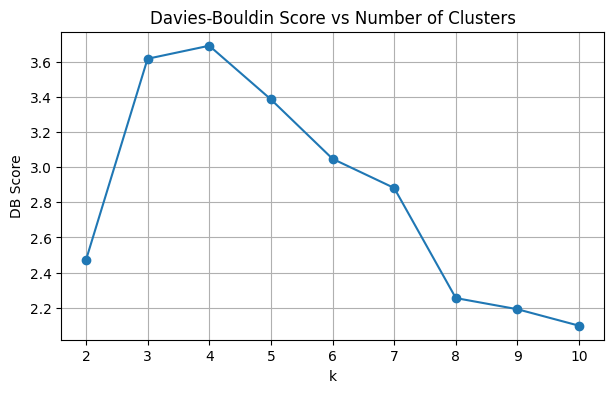

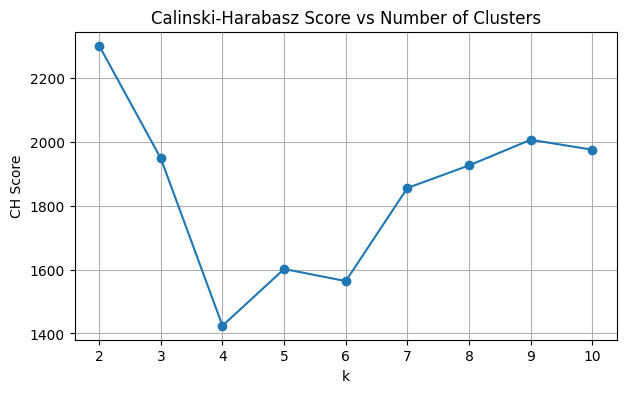

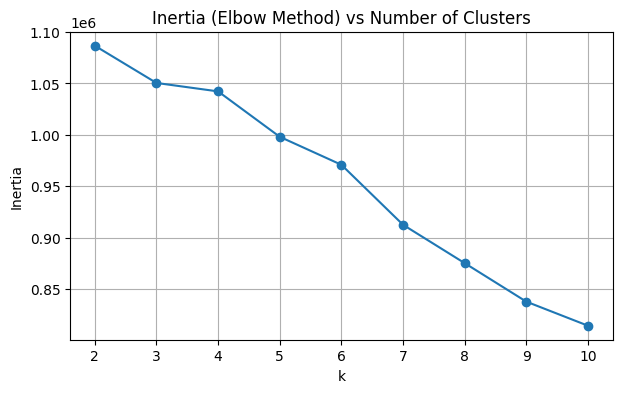

In [5]:
k_values = range(2, 11)
silhouette_scores = []
db_scores = []
ch_scores = []
inertias = []

for k in k_values:
    kmeans_k = KMeans(n_clusters=k, random_state=42)
    labels_k = kmeans_k.fit_predict(X_pca)

    silhouette_scores.append(silhouette_score(X_pca, labels_k))
    db_scores.append(davies_bouldin_score(X_pca, labels_k))
    ch_scores.append(calinski_harabasz_score(X_pca, labels_k))
    inertias.append(kmeans_k.inertia_)

# Plot Silhouette
plt.figure(figsize=(7, 4))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Plot DB Index
plt.figure(figsize=(7, 4))
plt.plot(k_values, db_scores, marker='o')
plt.title("Davies-Bouldin Score vs Number of Clusters")
plt.xlabel("k")
plt.ylabel("DB Score")
plt.grid(True)
plt.show()

# Plot CH Score
plt.figure(figsize=(7, 4))
plt.plot(k_values, ch_scores, marker='o')
plt.title("Calinski-Harabasz Score vs Number of Clusters")
plt.xlabel("k")
plt.ylabel("CH Score")
plt.grid(True)
plt.show()

# Plot Inertia (Elbow)
plt.figure(figsize=(7, 4))
plt.plot(k_values, inertias, marker='o')
plt.title("Inertia (Elbow Method) vs Number of Clusters")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()
